In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

class SkeletonDataset(Dataset):
    """
    Custom Dataset cho dữ liệu skeleton.
    Đọc dữ liệu từ file .npy và label từ file .pkl,
    sau đó định hình lại cho phù hợp với mô hình RNN/GRU.
    """
    def __init__(self, data_path, label_path):
        # Tải label
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

        # Tải dữ liệu và chuyển sang tensor
        # Dữ liệu gốc có shape (N, C, T, V, M)
        raw_data = np.load(data_path)
        self.data = torch.from_numpy(raw_data).float()

        # Thông tin shape
        self.N, self.C, self.T, self.V, self.M = self.data.shape
        print(f"Loaded data from {data_path} with shape: ({self.N}, {self.C}, {self.T}, {self.V}, {self.M})")


    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Lấy dữ liệu và label tại index
        sample_data = self.data[index] # Shape: (C, T, V, M)
        label = self.labels[index]

        # Thay đổi shape để phù hợp với GRU
        # Chuyển (C, T, V, M) -> (T, C, V, M)
        sample_data = sample_data.permute(1, 0, 2, 3)

        # Làm phẳng các chiều C, V, M thành một vector đặc trưng duy nhất cho mỗi bước thời gian T
        # Shape sau khi làm phẳng: (T, C * V * M)
        # Ví dụ: (20, 3 * 61 * 1) = (20, 183)
        flattened_data = sample_data.reshape(self.T, -1)

        return flattened_data, torch.tensor(label, dtype=torch.long)

In [11]:
import random
def set_seed(seed_value):
    random.seed(seed_value) # Python's random module
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch on CPU
    torch.cuda.manual_seed_all(seed_value) # PyTorch on all GPUs (if available)
    
    # Cấu hình cho thuật toán cuDNN (thường được sử dụng bởi PyTorch trên GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed_value}")

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedGRUModel(nn.Module):
    """
    Mô hình GRU đa lớp phức tạp, tương đương với phiên bản Keras đã cho.
    """
    def __init__(self, input_size, num_classes):
        super(AdvancedGRUModel, self).__init__()

        # --- Lớp GRU ---
        # Keras: GRU(128, return_sequences=True, activation='relu')
        # PyTorch: nn.GRU không hỗ trợ trực tiếp activation='relu'. 
        # Chúng ta sẽ sử dụng nn.GRU tiêu chuẩn và thảo luận về điểm này bên dưới.
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0)

        self.gru2 = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(0)

        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(0)
        
        self.gru4 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.dropout4 = nn.Dropout(0)

        # Lớp GRU cuối cùng, tương đương return_sequences=False
        self.gru5 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)

        # --- Khối Classifier (MLP) ---
        # Sử dụng nn.Sequential để nhóm các lớp Dense lại cho gọn gàng
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),       # Tương đương BatchNormalization() sau GRU
            nn.Linear(512, 512),
            nn.ReLU(),                 # Tương đương activation='relu'
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes) # Lớp output, không có softmax (xem giải thích)
        )

    def forward(self, x):
        # Luồng dữ liệu qua các lớp GRU
        # self.gru(x) trả về (output, h_n)
        # output có shape (batch, seq_len, hidden_size)
        # h_n là hidden state cuối cùng
        
        # return_sequences=True
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)
        out = self.dropout2(out)

        out, _ = self.gru3(out)
        out = self.dropout3(out)

        out, _ = self.gru4(out)
        out = self.dropout4(out)

        # Lớp GRU cuối, tương đương return_sequences=False
        out, _ = self.gru5(out)
        
        # Lấy output của bước thời gian cuối cùng
        out = out[:, -1, :] # Shape: (batch, hidden_size)

        # Cho qua khối classifier
        out = self.classifier(out)
        
        return out

In [ ]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện model trong một epoch."""
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá model trên tập validation hoặc test."""
    model.eval()  # Chuyển model sang chế độ evaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Không cần tính gradient khi đánh giá
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + clip grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer + scheduler
        optimizer.step()
        scheduler.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [15]:
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
if __name__ == '__main__':
    # --- 1. Cấu hình & Hyperparameters ---
    DATA_DIR = '/workspace/data/convert_data/npy_converted_full'
    NUM_CLASSES  = 3380
    NUM_EPOCHS   = 100
    BATCH_SIZE   = 256
    LEARNING_RATE= 0.001

    set_seed(42)

    # --- 2. Chuẩn bị Dữ liệu ---
    train_dataset = SkeletonDataset(f'{DATA_DIR}/train_data.npy', f'{DATA_DIR}/train_label.pkl')
    val_dataset   = SkeletonDataset(f'{DATA_DIR}/val_data.npy',   f'{DATA_DIR}/val_label.pkl')
    test_dataset  = SkeletonDataset(f'{DATA_DIR}/test_data.npy',  f'{DATA_DIR}/test_label.pkl')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # --- 3. Model, Loss, Optimizer, Scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = AdvancedGRUModel(input_size=3*61*1, num_classes=NUM_CLASSES).to(device)
    print("--- Model Architecture ---")
    print(model)
    print("--------------------------")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 5,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    )

    # --- 4. Training Loop ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scheduler, device
        )
        print(f"Train  | Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val    | Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # --- 5. Final Test ---
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest   | Loss: {test_loss:.4f}  Acc: {test_acc:.4f}")
    # (Tùy chọn) Lưu model
    torch.save(model.state_dict(), '/workspace/data/log/advanced_gru_model.pth')
    print("Model saved to advanced_gru_model.pth")

Global seed set to 42


Loaded data from /workspace/data/convert_data/npy_converted_full/train_data.npy with shape: (234244, 3, 20, 61, 1)
Loaded data from /workspace/data/convert_data/npy_converted_full/val_data.npy with shape: (50204, 3, 20, 61, 1)
Loaded data from /workspace/data/convert_data/npy_converted_full/test_data.npy with shape: (53552, 3, 20, 61, 1)
Using device: cuda
--- Model Architecture ---
AdvancedGRUModel(
  (gru1): GRU(183, 128, batch_first=True)
  (dropout1): Dropout(p=0, inplace=False)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout2): Dropout(p=0, inplace=False)
  (gru3): GRU(128, 256, batch_first=True)
  (dropout3): Dropout(p=0, inplace=False)
  (gru4): GRU(256, 512, batch_first=True)
  (dropout4): Dropout(p=0, inplace=False)
  (gru5): GRU(512, 512, batch_first=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_fea

Training: 100%|██████████| 916/916 [00:09<00:00, 93.57it/s] 


Train  | Loss: 6.0803  Acc: 0.0317


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 130.73it/s]


Val    | Loss: 4.2121  Acc: 0.0859

--- Epoch 2/100 ---


Training: 100%|██████████| 916/916 [00:12<00:00, 73.70it/s] 


Train  | Loss: 3.1784  Acc: 0.1981


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.74it/s]


Val    | Loss: 4.0116  Acc: 0.1293

--- Epoch 3/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 85.77it/s] 


Train  | Loss: 2.0706  Acc: 0.3939


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.61it/s]


Val    | Loss: 2.4625  Acc: 0.3301

--- Epoch 4/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 86.40it/s] 


Train  | Loss: 1.4606  Acc: 0.5562


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.54it/s]


Val    | Loss: 1.2842  Acc: 0.6050

--- Epoch 5/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 79.26it/s]


Train  | Loss: 1.0835  Acc: 0.6691


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.44it/s]


Val    | Loss: 1.3772  Acc: 0.6024

--- Epoch 6/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 78.09it/s]


Train  | Loss: 0.7706  Acc: 0.7712


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.03it/s]


Val    | Loss: 0.9164  Acc: 0.7190

--- Epoch 7/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 78.32it/s] 


Train  | Loss: 0.5622  Acc: 0.8337


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.12it/s]


Val    | Loss: 0.7092  Acc: 0.7876

--- Epoch 8/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.95it/s] 


Train  | Loss: 0.4410  Acc: 0.8705


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.70it/s]


Val    | Loss: 0.9914  Acc: 0.7119

--- Epoch 9/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.55it/s] 


Train  | Loss: 0.3725  Acc: 0.8895


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 134.98it/s]


Val    | Loss: 0.5307  Acc: 0.8465

--- Epoch 10/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 83.26it/s] 


Train  | Loss: 0.3210  Acc: 0.9046


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.01it/s]


Val    | Loss: 0.5042  Acc: 0.8507

--- Epoch 11/100 ---


Training: 100%|██████████| 916/916 [00:12<00:00, 74.86it/s]


Train  | Loss: 0.2964  Acc: 0.9118


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.97it/s]


Val    | Loss: 0.5236  Acc: 0.8472

--- Epoch 12/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.04it/s] 


Train  | Loss: 0.2787  Acc: 0.9162


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.11it/s]


Val    | Loss: 0.4042  Acc: 0.8753

--- Epoch 13/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.69it/s] 


Train  | Loss: 0.2725  Acc: 0.9188


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 128.24it/s]


Val    | Loss: 0.5489  Acc: 0.8474

--- Epoch 14/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.76it/s] 


Train  | Loss: 0.2797  Acc: 0.9165


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.04it/s]


Val    | Loss: 0.4490  Acc: 0.8746

--- Epoch 15/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.80it/s] 


Train  | Loss: 0.2808  Acc: 0.9161


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 120.98it/s]


Val    | Loss: 0.4781  Acc: 0.8612

--- Epoch 16/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 79.40it/s]


Train  | Loss: 0.2913  Acc: 0.9132


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.18it/s]


Val    | Loss: 1.0545  Acc: 0.7486

--- Epoch 17/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 83.53it/s] 


Train  | Loss: 0.3004  Acc: 0.9094


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.92it/s]


Val    | Loss: 0.4530  Acc: 0.8682

--- Epoch 18/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.30it/s] 


Train  | Loss: 0.3162  Acc: 0.9043


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.95it/s]


Val    | Loss: 0.4969  Acc: 0.8596

--- Epoch 19/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.02it/s] 


Train  | Loss: 0.3211  Acc: 0.9031


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.09it/s]


Val    | Loss: 0.8531  Acc: 0.7935

--- Epoch 20/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.63it/s] 


Train  | Loss: 0.3425  Acc: 0.8962


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.23it/s]


Val    | Loss: 0.4243  Acc: 0.8759

--- Epoch 21/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.93it/s] 


Train  | Loss: 0.3761  Acc: 0.8861


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 121.68it/s]


Val    | Loss: 1.1899  Acc: 0.7099

--- Epoch 22/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.54it/s] 


Train  | Loss: 0.4111  Acc: 0.8747


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.29it/s]


Val    | Loss: 1.2346  Acc: 0.7043

--- Epoch 23/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.89it/s] 


Train  | Loss: 0.4433  Acc: 0.8657


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.84it/s]


Val    | Loss: 0.7294  Acc: 0.7955

--- Epoch 24/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 85.10it/s] 


Train  | Loss: 0.5166  Acc: 0.8444


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.70it/s]


Val    | Loss: 1.2828  Acc: 0.6919

--- Epoch 25/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.42it/s] 


Train  | Loss: 0.5640  Acc: 0.8307


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.16it/s]


Val    | Loss: 2.5191  Acc: 0.4993

--- Epoch 26/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.07it/s] 


Train  | Loss: 0.5841  Acc: 0.8241


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 129.27it/s]


Val    | Loss: 0.5961  Acc: 0.8178

--- Epoch 27/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.58it/s] 


Train  | Loss: 0.6525  Acc: 0.8048


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.29it/s]


Val    | Loss: 1.0199  Acc: 0.7191

--- Epoch 28/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.94it/s] 


Train  | Loss: 0.7914  Acc: 0.7666


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.66it/s]


Val    | Loss: 0.8289  Acc: 0.7539

--- Epoch 29/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.17it/s] 


Train  | Loss: 0.8485  Acc: 0.7501


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.28it/s]


Val    | Loss: 0.8361  Acc: 0.7452

--- Epoch 30/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.18it/s] 


Train  | Loss: 0.8388  Acc: 0.7486


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.50it/s]


Val    | Loss: 1.7151  Acc: 0.5926

--- Epoch 31/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.33it/s] 


Train  | Loss: 1.7893  Acc: 0.5494


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.64it/s]


Val    | Loss: 1.8035  Acc: 0.5272

--- Epoch 32/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.06it/s] 


Train  | Loss: 1.2590  Acc: 0.6379


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 131.78it/s]


Val    | Loss: 1.6657  Acc: 0.5551

--- Epoch 33/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.92it/s] 


Train  | Loss: 1.3847  Acc: 0.6059


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.53it/s]


Val    | Loss: 1.4942  Acc: 0.5790

--- Epoch 34/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.47it/s] 


Train  | Loss: 1.3382  Acc: 0.6149


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.34it/s]


Val    | Loss: 2.1216  Acc: 0.4726

--- Epoch 35/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.40it/s] 


Train  | Loss: 1.7079  Acc: 0.5298


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.30it/s]


Val    | Loss: 1.3504  Acc: 0.6165

--- Epoch 36/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.26it/s] 


Train  | Loss: 1.2991  Acc: 0.6205


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.25it/s]


Val    | Loss: 2.0710  Acc: 0.4829

--- Epoch 37/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.67it/s] 


Train  | Loss: 1.3605  Acc: 0.6100


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.41it/s]


Val    | Loss: 1.6592  Acc: 0.5569

--- Epoch 38/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.62it/s] 


Train  | Loss: 1.2479  Acc: 0.6321


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 129.23it/s]


Val    | Loss: 1.6281  Acc: 0.5465

--- Epoch 39/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.86it/s] 


Train  | Loss: 1.2387  Acc: 0.6345


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.16it/s]


Val    | Loss: 1.2154  Acc: 0.6541

--- Epoch 40/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.51it/s] 


Train  | Loss: 1.2965  Acc: 0.6237


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.74it/s]


Val    | Loss: 1.3964  Acc: 0.6160

--- Epoch 41/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 76.94it/s] 


Train  | Loss: 1.1445  Acc: 0.6555


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.59it/s]


Val    | Loss: 1.1881  Acc: 0.6509

--- Epoch 42/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 91.02it/s] 


Train  | Loss: 0.7899  Acc: 0.7507


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.11it/s]


Val    | Loss: 0.9301  Acc: 0.8042

--- Epoch 43/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 82.67it/s]


Train  | Loss: 0.6639  Acc: 0.7874


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 130.31it/s]


Val    | Loss: 1.2152  Acc: 0.6918

--- Epoch 44/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.01it/s]


Train  | Loss: 0.6540  Acc: 0.7895


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.13it/s]


Val    | Loss: 1.1324  Acc: 0.7444

--- Epoch 45/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 91.01it/s] 


Train  | Loss: 0.5949  Acc: 0.8067


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.74it/s]


Val    | Loss: 0.7671  Acc: 0.7893

--- Epoch 46/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 81.81it/s] 


Train  | Loss: 0.5565  Acc: 0.8182


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.11it/s]


Val    | Loss: 0.6941  Acc: 0.8245

--- Epoch 47/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.74it/s] 


Train  | Loss: 0.5528  Acc: 0.8186


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.03it/s]


Val    | Loss: 0.7303  Acc: 0.8143

--- Epoch 48/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.52it/s]


Train  | Loss: 0.5402  Acc: 0.8231


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.13it/s]


Val    | Loss: 0.6651  Acc: 0.8011

--- Epoch 49/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 91.79it/s] 


Train  | Loss: 0.5201  Acc: 0.8288


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.65it/s]


Val    | Loss: 0.5873  Acc: 0.8394

--- Epoch 50/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 82.48it/s] 


Train  | Loss: 0.4498  Acc: 0.8500


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.41it/s]


Val    | Loss: 0.4567  Acc: 0.8630

--- Epoch 51/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.20it/s] 


Train  | Loss: 0.4520  Acc: 0.8492


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 132.35it/s]


Val    | Loss: 0.6377  Acc: 0.8434

--- Epoch 52/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.85it/s] 


Train  | Loss: 0.4264  Acc: 0.8564


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 132.99it/s]


Val    | Loss: 0.5621  Acc: 0.8508

--- Epoch 53/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.38it/s] 


Train  | Loss: 0.3807  Acc: 0.8703


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.42it/s]


Val    | Loss: 0.7495  Acc: 0.8411

--- Epoch 54/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.46it/s] 


Train  | Loss: 0.3570  Acc: 0.8781


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.20it/s]


Val    | Loss: 0.5542  Acc: 0.8801

--- Epoch 55/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 86.79it/s] 


Train  | Loss: 0.3551  Acc: 0.8794


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.69it/s]


Val    | Loss: 0.4091  Acc: 0.8878

--- Epoch 56/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.82it/s] 


Train  | Loss: 0.3154  Acc: 0.8912


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.11it/s]


Val    | Loss: 0.4232  Acc: 0.8911

--- Epoch 57/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.41it/s] 


Train  | Loss: 0.2714  Acc: 0.9050


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 121.60it/s]


Val    | Loss: 0.7926  Acc: 0.8920

--- Epoch 58/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 81.51it/s]


Train  | Loss: 0.2582  Acc: 0.9088


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 130.32it/s]


Val    | Loss: 0.5772  Acc: 0.8824

--- Epoch 59/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.30it/s] 


Train  | Loss: 0.2731  Acc: 0.9049


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.29it/s]


Val    | Loss: 0.4528  Acc: 0.9047

--- Epoch 60/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 91.00it/s] 


Train  | Loss: 0.2676  Acc: 0.9066


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.67it/s]


Val    | Loss: 0.3941  Acc: 0.8918

--- Epoch 61/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.83it/s] 


Train  | Loss: 0.2482  Acc: 0.9126


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.49it/s]


Val    | Loss: 0.2853  Acc: 0.9059

--- Epoch 62/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.01it/s] 


Train  | Loss: 0.2273  Acc: 0.9197


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 130.47it/s]


Val    | Loss: 0.4453  Acc: 0.8905

--- Epoch 63/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.15it/s] 


Train  | Loss: 0.2415  Acc: 0.9159


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.36it/s]


Val    | Loss: 0.3569  Acc: 0.9013

--- Epoch 64/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.94it/s] 


Train  | Loss: 0.2127  Acc: 0.9243


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.05it/s]


Val    | Loss: 0.3097  Acc: 0.9191

--- Epoch 65/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 96.66it/s] 


Train  | Loss: 0.1879  Acc: 0.9318


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.57it/s]


Val    | Loss: 0.4329  Acc: 0.9294

--- Epoch 66/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 95.68it/s] 


Train  | Loss: 0.1785  Acc: 0.9356


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 121.54it/s]


Val    | Loss: 0.2911  Acc: 0.9322

--- Epoch 67/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 85.58it/s] 


Train  | Loss: 0.1665  Acc: 0.9398


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.91it/s]


Val    | Loss: 0.2068  Acc: 0.9310

--- Epoch 68/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.56it/s] 


Train  | Loss: 0.1475  Acc: 0.9453


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.25it/s]


Val    | Loss: 0.2301  Acc: 0.9500

--- Epoch 69/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 96.92it/s] 


Train  | Loss: 0.1361  Acc: 0.9500


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.98it/s]


Val    | Loss: 0.1479  Acc: 0.9516

--- Epoch 70/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 88.35it/s] 


Train  | Loss: 0.1298  Acc: 0.9520


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.35it/s]


Val    | Loss: 0.2727  Acc: 0.9524

--- Epoch 71/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.78it/s] 


Train  | Loss: 0.1210  Acc: 0.9552


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.57it/s]


Val    | Loss: 0.2611  Acc: 0.9496

--- Epoch 72/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.04it/s] 


Train  | Loss: 0.1054  Acc: 0.9602


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.55it/s]


Val    | Loss: 0.5475  Acc: 0.9627

--- Epoch 73/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 81.60it/s]


Train  | Loss: 0.0967  Acc: 0.9635


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.43it/s]


Val    | Loss: 0.3622  Acc: 0.9589

--- Epoch 74/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.24it/s] 


Train  | Loss: 0.0870  Acc: 0.9666


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.56it/s]


Val    | Loss: 0.3497  Acc: 0.9710

--- Epoch 75/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 90.11it/s] 


Train  | Loss: 0.0743  Acc: 0.9717


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.28it/s]


Val    | Loss: 0.2975  Acc: 0.9671

--- Epoch 76/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.75it/s] 


Train  | Loss: 0.0718  Acc: 0.9724


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.10it/s]


Val    | Loss: 0.1798  Acc: 0.9748

--- Epoch 77/100 ---


Training: 100%|██████████| 916/916 [00:12<00:00, 74.65it/s]


Train  | Loss: 0.0621  Acc: 0.9758


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.75it/s]


Val    | Loss: 0.1256  Acc: 0.9726

--- Epoch 78/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 90.65it/s] 


Train  | Loss: 0.0631  Acc: 0.9754


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.42it/s]


Val    | Loss: 0.5763  Acc: 0.9802

--- Epoch 79/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 83.88it/s]


Train  | Loss: 0.0476  Acc: 0.9807


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.05it/s]


Val    | Loss: 0.1009  Acc: 0.9813

--- Epoch 80/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 79.71it/s]


Train  | Loss: 0.0450  Acc: 0.9824


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 131.27it/s]


Val    | Loss: 0.2317  Acc: 0.9767

--- Epoch 81/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 90.85it/s] 


Train  | Loss: 0.0394  Acc: 0.9843


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.84it/s]


Val    | Loss: 0.3322  Acc: 0.9812

--- Epoch 82/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 96.82it/s] 


Train  | Loss: 0.0343  Acc: 0.9862


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 127.76it/s]


Val    | Loss: 0.5774  Acc: 0.9836

--- Epoch 83/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.16it/s] 


Train  | Loss: 0.0304  Acc: 0.9876


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.44it/s]


Val    | Loss: 0.3461  Acc: 0.9884

--- Epoch 84/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 91.61it/s] 


Train  | Loss: 0.0259  Acc: 0.9894


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.44it/s]


Val    | Loss: 0.6717  Acc: 0.9873

--- Epoch 85/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.52it/s] 


Train  | Loss: 0.0222  Acc: 0.9910


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.78it/s]


Val    | Loss: 0.2761  Acc: 0.9900

--- Epoch 86/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.34it/s] 


Train  | Loss: 0.0172  Acc: 0.9929


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.74it/s]


Val    | Loss: 0.2874  Acc: 0.9917

--- Epoch 87/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 88.75it/s] 


Train  | Loss: 0.0154  Acc: 0.9937


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.93it/s]


Val    | Loss: 0.6241  Acc: 0.9902

--- Epoch 88/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 89.80it/s] 


Train  | Loss: 0.0146  Acc: 0.9940


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.87it/s]


Val    | Loss: 0.1205  Acc: 0.9931

--- Epoch 89/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 94.29it/s] 


Train  | Loss: 0.0114  Acc: 0.9952


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 121.80it/s]


Val    | Loss: 0.3860  Acc: 0.9930

--- Epoch 90/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 80.81it/s] 


Train  | Loss: 0.0103  Acc: 0.9955


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 126.89it/s]


Val    | Loss: 0.2544  Acc: 0.9948

--- Epoch 91/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 82.97it/s] 


Train  | Loss: 0.0088  Acc: 0.9962


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.89it/s]


Val    | Loss: 0.7194  Acc: 0.9944

--- Epoch 92/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 81.88it/s]


Train  | Loss: 0.0076  Acc: 0.9967


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.23it/s]


Val    | Loss: 0.8057  Acc: 0.9945

--- Epoch 93/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 87.83it/s] 


Train  | Loss: 0.0066  Acc: 0.9971


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.72it/s]


Val    | Loss: 0.3250  Acc: 0.9944

--- Epoch 94/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 78.61it/s]


Train  | Loss: 0.0059  Acc: 0.9974


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 122.09it/s]


Val    | Loss: 0.7473  Acc: 0.9948

--- Epoch 95/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.52it/s] 


Train  | Loss: 0.0053  Acc: 0.9975


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 125.37it/s]


Val    | Loss: 0.4283  Acc: 0.9951

--- Epoch 96/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 93.20it/s] 


Train  | Loss: 0.0048  Acc: 0.9978


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.82it/s]


Val    | Loss: 0.7735  Acc: 0.9950

--- Epoch 97/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 78.74it/s]


Train  | Loss: 0.0044  Acc: 0.9980


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 120.93it/s]


Val    | Loss: 0.5414  Acc: 0.9952

--- Epoch 98/100 ---


Training: 100%|██████████| 916/916 [00:10<00:00, 84.36it/s] 


Train  | Loss: 0.0043  Acc: 0.9982


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.48it/s]


Val    | Loss: 0.6577  Acc: 0.9942

--- Epoch 99/100 ---


Training: 100%|██████████| 916/916 [00:09<00:00, 92.61it/s] 


Train  | Loss: 0.0039  Acc: 0.9983


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 124.34it/s]


Val    | Loss: 0.4382  Acc: 0.9952

--- Epoch 100/100 ---


Training: 100%|██████████| 916/916 [00:11<00:00, 82.68it/s] 


Train  | Loss: 0.0041  Acc: 0.9983


Evaluating: 100%|██████████| 197/197 [00:01<00:00, 123.59it/s]


Val    | Loss: 0.3992  Acc: 0.9950


Evaluating: 100%|██████████| 210/210 [00:01<00:00, 128.93it/s]


Test   | Loss: 0.5934  Acc: 0.9795


In [18]:
import matplotlib.pyplot as plt

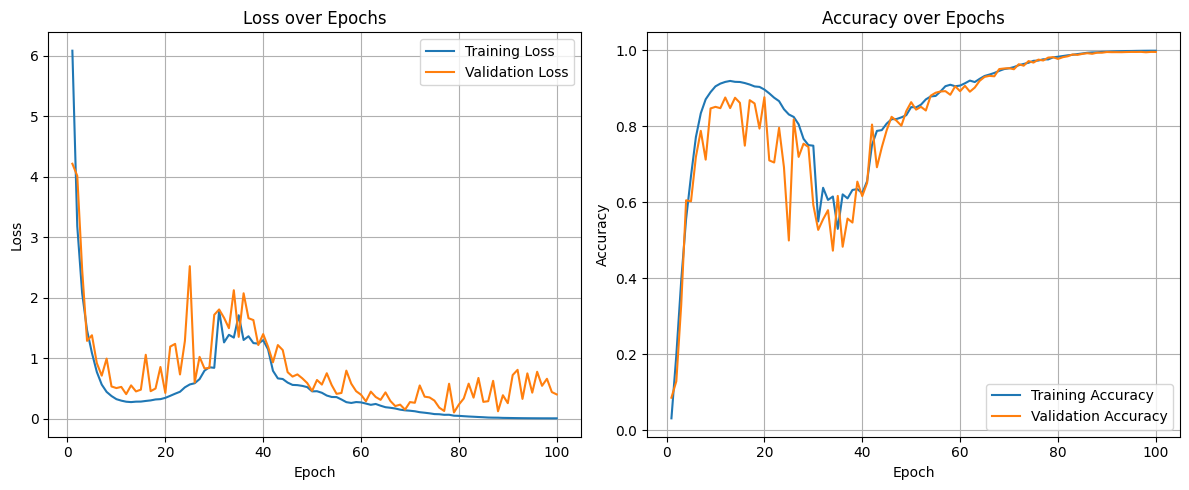

Plots generated successfully!


In [19]:
epochs_range = range(1, NUM_EPOCHS + 1) 
plt.figure(figsize=(12, 5)) # Tạo một hình vẽ mới với kích thước 12x5 inches
plt.subplot(1, 2, 1) # Tạo biểu đồ con thứ nhất (1 hàng, 2 cột)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # Tạo biểu đồ con thứ hai (1 hàng, 2 cột)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ con để tránh chồng chéo
plt.show() # Hiển thị các biểu đồ
print("Plots generated successfully!")

In [ ]:
# if __name__ == '__main__':
#     # --- 1. Cấu hình & Hyperparameters ---
#     DATA_DIR = '/workspace/data/convert_data/npy_converted_full'  # THAY ĐỔI ĐƯỜNG DẪN NÀY
#     NUM_CLASSES = 3380                         # THAY ĐỔI số lượng lớp (class) nếu cần
#     set_seed(42)  # Đặt seed toàn cục để đảm bảo tính tái lập
#     # Model Hyperparameters
#     # Với AdvancedGRUModel, các giá trị hidden_size và num_layers đã được định nghĩa
#     # cứng bên trong kiến trúc model, nên chúng ta không cần truyền vào nữa.
#     INPUT_SIZE = 3 * 61 * 1  # C * V * M
    
#     # Training Hyperparameters
#     NUM_EPOCHS = 100
#     BATCH_SIZE = 256
#     LEARNING_RATE = 0.001

#     # --- 2. Chuẩn bị Dữ liệu ---
#     # Tạo Datasets (phần này giữ nguyên)
#     train_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/train_data.npy',
#         label_path=f'{DATA_DIR}/train_label.pkl'
#     )
#     val_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/val_data.npy',
#         label_path=f'{DATA_DIR}/val_label.pkl'
#     )
#     test_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/test_data.npy',
#         label_path=f'{DATA_DIR}/test_label.pkl'
#     )

#     # Tạo DataLoaders (phần này giữ nguyên)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#     # --- 3. Khởi tạo Model, Loss, Optimizer ---
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # **THAY ĐỔI CHÍNH Ở ĐÂY**
#     # Khởi tạo model AdvancedGRUModel với các tham số cần thiết
#     model = AdvancedGRUModel(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
#     print("--- Model Architecture ---")
#     print(model)
#     print("--------------------------")
    
#     # Hàm mất mát và trình tối ưu hóa (giữ nguyên)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     # --- 4. Vòng lặp Huấn luyện --- (giữ nguyên)
#     for epoch in range(NUM_EPOCHS):
#         print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#         print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)
#         print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#     print("\n--- Training Finished ---")

#     # --- 5. Đánh giá cuối cùng trên tập Test --- (giữ nguyên)
#     test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#     print(f"\nFinal Test Results | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

#     # (Tùy chọn) Lưu model
#     # torch.save(model.state_dict(), 'advanced_gru_model.pth')
#     # print("Model saved to advanced_gru_model.pth")